# Implementación del método

Este notebook muestra paso a paso cómo funciona el método de parametrización para el mapeo estándar. Recordemos que antes ya se calcularon los puntos fijos del mapeo y se hizo un análisis de los mismos por lo que nos concentraremos en sólo aplicar de manera clara y paso a paso el método. Hacerlo de esta manera nos ayudará a comprender mejor cómo se implementó método de manera general. 
Dado que conocemos ya los puntos fijos entonces nos concentraremos en calcular la variedad inestable, la cual se podrá elegir en términos de escoger el valor propio con el signo negativo que ya se calculó en el N3. 

En primer lugar hay que notar que como queremos implementar eso de manera general tenemos que hacer el cálculo de los valores propios en un inicio. Luego de esto se puede proceder con el calculo de cada variedad. 


Como ya sabemos cuáles son los puntos fijos necesitamos ahora calcular los polinomios que serán la parametrización de la variedad.Para ello debemos resolver la ecuación de invariancia.
$$F_{\epsilon}\circ P=P\circ \lambda$$

In [1]:
#usaremos el paquete de TaylorSeries
using TaylorSeries


In [3]:
#necesitamos tambien definir el mapeo standar 
"""EstandarMap(θ,p,k)
   
   Función que define el mapeo estándar.
  

   Argumentos:
   -θ : posición
   -p : momento
   -k : constante del mapeo
"""
function EstandarMap(θ,p,k)
    
    θ_n = mod2pi(θ+p)
    p_n = mod2pi(p+k*sin(θ_n))
    
    return [θ_n,p_n]
    
    
end


    

EstandarMap

Definimos el valor de la constante del mapeo que usaremos en este caso. 

In [4]:
ke=0.3

0.3

                                                     
                                                    ORDEN 1 


Dado que queremos que $T_{x}$, $T_{p}$ sean polinomios necesitamos construirlos como dos polinomios de los cuales solo sabemos su primer coeficiente pero la idea es ir calculando los términos en cada iteración. Escribirmos los coeficientes que buscamos como un polinomio a su vez de orden mayor a uno.

In [5]:
#Queremos que los polinomios para θ, p sean de orden uno, eso no influye en el orden del coeficiente que estamos calculando
θ,p = set_variables(Float64,"θ p",order=2)

2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖³)
  1.0 p + 𝒪(‖x‖³)

In [6]:
#Ahora necesitamos los polinomios que parametrizan a las variedades en específico, estos serán tipo Taylor1.TaylorN
P_θ=Taylor1([θ], 1)
P_p=Taylor1([p], 1)
#el orden de estos ya es importante para cada iteración, aquí es uno porque estamos en el coeficiente de primer grado
print(P_θ,P_p)


  1.0 θ + 𝒪(‖x‖³) + 𝒪(t²)  1.0 p + 𝒪(‖x‖³) + 𝒪(t²)

In [7]:
#Aplicamos el mapeo a estos dos polinomios
Orden1=EstandarMap(P_θ,P_p,ke)

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
   1.0 θ + 1.0 p + 𝒪(‖x‖³) + 𝒪(t²)
   0.3 θ + 1.3 p + 𝒪(‖x‖³) + 𝒪(t²)

Hasta este momento tenemos calculado la parte de la ecuación cohomológica que corresponde a la composición de $f_{\epsilon} \circ P$, es decir creamos un arreglo de polinomios P que después evaluamos en la función $f_{\epsilon}$. Construiremos la otra composición que aparece en la ecuación cohomológica más adelante. Antes de eso debemos pensar cómo se resolverá esta ecuación, la forma más fácil es escribirla como un sistema en forma matricial. 
$$\mathbb{A}\textbf{v}=\textbf{w} $$
Donde la matriz A contiene los coeficientes que aparecen en los polinomios de acuerdo a cada variable. Mientras que la x representa el vector $(\theta,p)$ y $w$ el vector de términos independientes de los polinomios. 

Para escribirlo de esta manera usaremos una función dentro de TaylorSeries que es el jacobiano. El jacobiano como recordamos es una matriz formada por las derivadas parciales de los dos polinomios para cada una de las variables. En este caso dos variables y dos polinomios nos llevan a una matriz de $2 \times 2$ formada por :
$$ \left( \begin{array}{cc}
\frac{\partial f_{x}}{\partial \theta} & \frac{\partial f_{p}}{\partial \theta}  \\
\frac{\partial f_{x}}{\partial p} & \frac{\partial f_{p}}{\partial p}  \end{array} \right) $$

In [8]:
#al calcular el jacobiano obtendremos sólo los valores de los coeficientes los cuales 
# son de tipo TaylorN
JPO=jacobian(Orden1)


2×2 Array{TaylorSeries.Taylor1{Float64},2}:
  1.0 + 𝒪(t²)   1.0 + 𝒪(t²)
  0.3 + 𝒪(t²)   1.3 + 𝒪(t²)

In [9]:
#como los valores que contiene el jacobiano son de tipo TaylorN y para usarlos como necesitamos
# se deben tener en Float64 vamos a obtenerlos de la siguente manera. 
JacFl = Array{Float64}(2,2)
for ind in eachindex(JPO)
                JacFl[ind] = JPO[ind].coeffs[1]
end
#usamos la matriz JacFl como auxiliar para encontrar los valores flotantes
@show(JacFl)

JacFl = [1.0 1.0; 0.3 1.3]


2×2 Array{Float64,2}:
 1.0  1.0
 0.3  1.3

La matriz que aparece arriba es una que ya podemos usar para calcular los valores y vectores propios. Necesitamos sólo uno de ellos.

In [10]:
# eig () es una función que calcula los valores y vectores propios de una matriz y los da en ese orden en forma de vector.
JPO=JacFl
eval,eve=eig(JPO)

([0.582109, 1.71789], [-0.922675 -0.812346; 0.385578 -0.583176])

In [11]:
# dado que usaremos la variedad inestable, entonces usamos el segundo valor propio
λ=eval[2]
print(λ,eve)



1.7178908345800274[-0.922675 -0.812346; 0.385578 -0.583176]

Tomamos por ende el segundo vector propio, los coeficientes de este vector serán los coeficientes de primer orden en los polinomios. 

In [12]:
vec=eve[:,2]
# decimos que vec es un arreglo de contiene los valores correspondientes a los lugares [1,2], [2,2] de eve.

2-element Array{Float64,1}:
 -0.812346
 -0.583176

In [13]:
#queremos revisar la estabilidad de tipo de las variables Pθ,x
@show(P_θ)
@show(typeof(P_θ))
@show(Orden1[1])
@show(typeof(Orden1[1]))


P_θ =   1.0 θ + 𝒪(‖x‖³) + 𝒪(t²)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Orden1[1] =   1.0 θ + 1.0 p + 𝒪(‖x‖³) + 𝒪(t²)
typeof(Orden1[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                                  ORDEN 2

A partir de este término la forma de obtener los coeficientes se vuelve monótona, esto facilita que podamos sintetizar
todos los pasos en funciones. Antes de eso calcularemos cada término por separado. La forma de comenzar a calcular cada coeficiente no cambia con respecto al primero. 

In [16]:

#Queremos hacer la misma idea para este orden, recordemos que el orden de este polinomio no influye por ahora en el cálculo
# ya que en los términos que no aparecen explícitamente sirven para justo calcular la parte que no conocemos.

θ,p = set_variables(Float64,"θ p",order=1)

2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖²)
  1.0 p + 𝒪(‖x‖²)

Para los nuevos polinomios agregamos los valores que calculamos en el paso anterior, además de las variables x,p como series de Taylor.

In [17]:
#usamos los valores ya calculados en el orden 1 para x,p de primer orden, estos los incluyo en una lista junto 
#con  el polinomio que representa a x,p  tipo TaylorN 
P_θ=Taylor1([0.,vec[1],θ],2)
P_p=Taylor1([0.,vec[2],p],2)

 ( - 0.5831757547123116 + 𝒪(‖x‖¹)) t + ( 1.0 p + 𝒪(‖x‖²)) t² + 𝒪(t³)

In [18]:
#aplicamos el mapeo
SO=EstandarMap(P_θ,P_p,ke)

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t² + 𝒪(t³)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.3 θ + 1.3 p + 𝒪(‖x‖²)) t² + 𝒪(t³)

Para el lado derecho de la ecuación cohomológica necesitamos un vector de lambdas, pues recordemos  
$$ \Sigma_{n=1}^{\inf}a_{n}t^{n}\lambda^{n}$$
$$\Sigma_{n=1}^{\inf}b_{n}t^{n}\lambda^{n}$$


In [19]:
# como nos falta el otro lado de la ecuación cohomológica definimos un vector de lambdas
vλ=[0.0,λ,λ^2]

3-element Array{Float64,1}:
 0.0    
 1.71789
 2.95115

In [20]:
#y definimos también un polinomio para las lambdas, del mismo orden que el polinomio de P_θ,P_p
# que juega la parte de a_{n}\lambda^{n}
θλt=Taylor1(vλ.*[0.,vec[1],θ],2)
pλt=Taylor1(vλ.*[0.,vec[2],p],2)
λvec=[θλt,pλt]

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 2.9511489195340634 θ + 𝒪(‖x‖²)) t² + 𝒪(t³)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 2.9511489195340634 p + 𝒪(‖x‖²)) t² + 𝒪(t³)

Ahora ya tengo las dos partes de la ecuación y debo igualarlas para resolver. SO representa la parte de la primera
 composición mientras que $λvec$ representa la parte derecha de la ecuación de invariancia. Al restarlas estoy resolviendo 
 $$f_{\epsilon}\circ P- P \circ \lambda=0 $$. En este caso no esta igualada a cero puesto que estamos tratando de calcular el siguente término, es decir van a diferir justo en ese término. 

In [21]:
#Restando ambos vectores que representan la ecuación cohomológica encontraremos los términos que faltan
# de empatar
Ecua=SO-λvec


2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.9511489195340634 θ + 1.0 p + 𝒪(‖x‖²)) t² + 𝒪(t³)
    ( 0.3 θ - 1.6511489195340634 p + 𝒪(‖x‖²)) t² + 𝒪(t³)

En este paso nos podemos dar cuenta que sólo aprece el término de orden dos puesto que el de orden uno ya lo calculamos. 

Notemos que hay un pequeño error, pues aparece un número en el polinomio asociado a $\theta$ de orden 1, sin embargo este número es del orden de $10^{-16}$ lo cual nos dice que es un error numérico.

In [22]:

# de esta ecuación necesitamos solo los de segundo orden, así que los extraemos manualmente 
θ2=Ecua[1].coeffs[3]
p2=Ecua[2].coeffs[3]
vec2=[θ2,p2]

2-element Array{TaylorSeries.TaylorN{Float64},1}:
  - 1.9511489195340634 θ + 1.0 p + 𝒪(‖x‖²)
    0.3 θ - 1.6511489195340634 p + 𝒪(‖x‖²)

In [23]:
#calculamos ahora el jacobiano de este vector, ya que los coeficientes serán parte de la matriz que queremos
JSO=jacobian(vec2)

2×2 Array{Float64,2}:
 -1.95115   1.0    
  0.3      -1.65115

In [24]:
#calculamos su determinante para ver si es cero, 
det(JSO)

2.9216374303387243

In [25]:
# como es distinto de cero y la ecuación esta igualada a cero entonces la única solución es la trivial
θ2=0.
p2=0.
vec2=[0.,0.]


2-element Array{Float64,1}:
 0.0
 0.0

Esto concuerda con lo que habíamos encontrado antes, los coeficientes de orden par son cero. 

In [26]:
#queremos revisar la estabilidad de las variables tx,x
@show(P_θ)
@show(typeof(P_θ))
@show(SO[1])
@show(typeof(SO[1]))
@show(θλt)
@show(typeof(θλt))
@show(Ecua[1])
@show(typeof(Ecua[1]))

P_θ =  ( - 0.8123460094785507 + 𝒪(‖x‖¹)) t + ( 1.0 θ + 𝒪(‖x‖²)) t² + 𝒪(t³)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
SO[1] =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t² + 𝒪(t³)
typeof(SO[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
θλt =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 2.9511489195340634 θ + 𝒪(‖x‖²)) t² + 𝒪(t³)
typeof(θλt) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Ecua[1] =  ( - 1.9511489195340634 θ + 1.0 p + 𝒪(‖x‖²)) t² + 𝒪(t³)
typeof(Ecua[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                                ORDEN 3

Para este orden comenzaremos a generar los vectores como en el caso anterior, lo que cambia en este caso es que
aparecen términos independientes en la ecuación comohológica. Esto resulta en que las solución ya no será la trivial como en el caso pasado.

In [27]:
#genramos un par de variables de tipo TaylorN de orden 3
θ,p = set_variables(Float64,"θ p",order=3)


2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖⁴)
  1.0 p + 𝒪(‖x‖⁴)

In [28]:
#generamos las variables con las que evaluamos el mapeo, notemos que deben de tener orden mayor al orden que estamos 
# calculando
P_θ=Taylor1([0.,vec[1],θ2,θ],4)
P_p=Taylor1([0.,vec[2],p2,p],4)


 ( - 0.5831757547123116 + 𝒪(‖x‖¹)) t + ( 1.0 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)

In [29]:
#aplicamos el mapeo 
TO=EstandarMap(P_θ,P_p,ke)


2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                       ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 1.0 θ + 1.0 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.1358876056468051 + 0.3 θ + 1.3 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)

In [30]:
#creamos un vector de lambdas que formará parte del lado derecho de la ecuación cohomo.
vλ=[0,λ,λ^2, λ^3]
θλt=Taylor1([0.,vec[1],θ2,θ].*vλ,4)
pλt=Taylor1([0.,vec[2],p2,p].*vλ,4)



 ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 5.069751680348318 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)

In [31]:
#lo usaremos como vector pues el mapeo regresa un vector
λvec=[θλt,pλt]


2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 5.069751680348318 θ + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 5.069751680348318 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)

In [32]:
#Escribimos la ecuación cohomo
Ecua=TO-λvec


2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                      ( - 4.069751680348318 θ + 1.0 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
  ( 0.1358876056468051 + 0.3 θ - 3.7697516803483184 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)

In [33]:
#notamos de nuevo que sólo sobreviven los términos de orden 3 y que hay un pequeño error en el término 1 
θ3=Ecua[1].coeffs[4]
p3=Ecua[2].coeffs[4]

 0.1358876056468051 + 0.3 θ - 3.7697516803483184 p + 𝒪(‖x‖⁴)

In [34]:
#Dado que en este momento comienzan a aparecer términos independientes en x, p necesitamos una forma de extraerlos
# primero estraemos los coeficientes de x, p como antes con el jacobiano. 
JTO=jacobian([θ3,p3])

2×2 Array{Float64,2}:
 -4.06975   1.0    
  0.3      -3.76975

In [35]:
#calculamos el determinante 
det(JTO)

15.041953235593466

In [36]:

#extraemos ahora los coeficientes independientes de x,p 
a= Ecua[1].coeffs[4].coeffs[1].coeffs[1]
b= Ecua[2].coeffs[4].coeffs[1].coeffs[1]
vecCoef=[-a,-b]


2-element Array{Float64,1}:
 -0.0     
 -0.135888

Dado que el determinante de la matriz es distinto de cero y los términos independientes son diferentes de cero entonces existe una solución no trivial. Para resolver este sitema utilizamos que :
$$JTO [\theta, p]^{T}=[a,b]^{T}$$
$$[\theta, p]^{T}=JTO^{-1}[a,b]^{T}$$

In [37]:

# entonces solo se trata de invertir el jacobiano y multiplicar con el vector del lado izquierdo
T3=JTO \ vecCoef


2-element Array{Float64,1}:
 0.00903391
 0.0367658 

In [38]:
#los valores que obtuvimos son los nuevos coeficientes de orden 3
θ3=T3[1]
p3=T3[2]
v3=[θ3,p3]

2-element Array{Float64,1}:
 0.00903391
 0.0367658 

In [39]:
#queremos revisar la estabilidad de las variables tx,x
@show(P_θ)
@show(typeof(P_θ))
@show(TO[1])
@show(typeof(TO[1]))
@show(θλt)
@show(typeof(θλt))
@show(Ecua[1])
@show(typeof(Ecua[1]))

P_θ =  ( - 0.8123460094785507 + 𝒪(‖x‖¹)) t + ( 1.0 θ + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
TO[1] =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 1.0 θ + 1.0 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
typeof(TO[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
θλt =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 5.069751680348318 θ + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
typeof(θλt) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Ecua[1] =  ( - 4.069751680348318 θ + 1.0 p + 𝒪(‖x‖⁴)) t³ + 𝒪(t⁵)
typeof(Ecua[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                                        ORDEN 4

In [40]:
#creamos las variables de tipo TaylorN
θ,p = set_variables(Float64,"θ p",order=1)


2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖²)
  1.0 p + 𝒪(‖x‖²)

In [41]:
#creamos las variables del mapeo que ya toman en cuenta los coeficientes que calculamos
P_θ=Taylor1([0.,vec[1],θ2,θ3,θ],5)
P_p=Taylor1([0.,vec[2],p2,p3,p],5)


 ( - 0.5831757547123116 + 𝒪(‖x‖¹)) t + ( 0.036765757927698775 + 𝒪(‖x‖¹)) t³ + ( 1.0 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)

In [46]:
#Le aplicamos el mapeo estándar
CO=EstandarMap(P_θ,P_p,ke)


2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                                           ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323034 + 𝒪(‖x‖¹)) t³ + ( 0.3 θ + 1.3 p + 𝒪(‖x‖²)) t⁴ + ( - 0.026611022998050755 + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁶)

In [49]:
#creamos la parte derecha de la ecuación
vλ=[0., λ, λ^2, λ^3, λ^4]
θλt=Taylor1([0.,vec[1],θ2,θ3,θ].*vλ,5)
pλt=Taylor1([0.,vec[2],p2,p3,p].*vλ,5)
print(xλt,pλt)


 ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 8.709279945267069 θ + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶) ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( 8.709279945267069 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)

In [50]:
#es más útil tener esta parte como un vector
λvec=[θλt,pλt]

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 8.709279945267069 θ + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( 8.709279945267069 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)

In [51]:
#escribimos la ecuación cohomo, para poder sacar el jacobiano
Ecua=CO-λvec


2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                                                                                    ( - 7.709279945267069 θ + 1.0 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
  ( - 2.7755575615628914e-17 + 𝒪(‖x‖¹)) t³ + ( 0.3 θ - 7.409279945267069 p + 𝒪(‖x‖²)) t⁴ + ( - 0.026611022998050755 + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁶)

In [52]:
#obtenemos los valores de orden 4 
θ4=Ecua[1].coeffs[5]
p4=Ecua[2].coeffs[5]





 0.3 θ - 7.409279945267069 p + 𝒪(‖x‖²)

In [53]:
#calculamos el jacobiano de estos términos, para obtener solo los coeficientes
JCO=jacobian([θ4,p4])

2×2 Array{Float64,2}:
 -7.70928   1.0    
  0.3      -7.40928

In [54]:
#calculamos el determinante para saber si podemos resolver el sistema_
det(JCO)

56.8202132909169

In [55]:
#dado que el determinante es distinto de cero y los valores independientes del sistema son cero
# la única solución es la trivial
T4=JCO\ [0.,0.]


2-element Array{Float64,1}:
 -0.0
 -0.0

In [57]:
#esta solución son los nuevos coeficientes del polinomio
θ4=T4[1]
p4=T4[2]

-0.0

De nuevo dado que es un término de orden par, los coeficientes fueron cero.

In [58]:
#queremos revisar la estabilidad de las variables tx,x
@show(P_θ)
@show(typeof(P_θ))
@show(CO[1])
@show(typeof(CO[1]))
@show(θλt)
@show(typeof(θλt))
@show(Ecua[1])
@show(typeof(Ecua[1]))

P_θ =  ( - 0.8123460094785507 + 𝒪(‖x‖¹)) t + ( 0.009033906934722882 + 𝒪(‖x‖¹)) t³ + ( 1.0 θ + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
CO[1] =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
typeof(CO[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
θλt =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 8.709279945267069 θ + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
typeof(θλt) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Ecua[1] =  ( - 7.709279945267069 θ + 1.0 p + 𝒪(‖x‖²)) t⁴ + 𝒪(t⁶)
typeof(Ecua[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                                 QUINTO ORDEN

In [59]:
#creamos las variables que representan a x,p de tipo TaylorN
θ,p = set_variables(Float64,"θ p",order=1)


2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖²)
  1.0 p + 𝒪(‖x‖²)

In [60]:
#definimos nuestros nuevos polinomios tomando en cuenta todos los coeficientes ya calculados
P_θ=Taylor1([0.,vec[1],θ2,θ3,θ4,θ],6)
P_p=Taylor1([0.,vec[2],p2,p3,p4,p],6)


 ( - 0.5831757547123116 + 𝒪(‖x‖¹)) t + ( 0.036765757927698775 + 𝒪(‖x‖¹)) t³ + ( 1.0 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)

In [62]:
#aplicamos el mapeo
QO=EstandarMap(P_θ,P_p,ke)

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                           ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323034 + 𝒪(‖x‖¹)) t³ + ( - 0.026611022998050755 + 0.3 θ + 1.3 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)

In [64]:
#creamos la otra parte de la ecuación cohomo
vλ=[0.,λ,λ^2,λ^3,λ^4,λ^5]
θλt=Taylor1([0.,vec[1],θ2,θ3,θ4,θ].*vλ,6)
pλt=Taylor1([0.,vec[2],p2,p3,p4,p].*vλ,6)
print(θλt,pλt)

 ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 14.96159219376594 θ + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷) ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( 14.96159219376594 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)

In [65]:
#nos es más útil como vector
λvec=[θλt,pλt]

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 14.96159219376594 θ + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( 14.96159219376594 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)

In [66]:
#escribimos la ecuación cohomo
Ecua=QO-λvec

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                                                                     ( - 13.96159219376594 θ + 1.0 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
  ( - 2.7755575615628914e-17 + 𝒪(‖x‖¹)) t³ + ( - 0.026611022998050755 + 0.3 θ - 13.661592193765939 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)

In [67]:
#obtenemos los coeficientes  que no son cero, es decir los de orden 5
θ5=Ecua[1].coeffs[6]
p5=Ecua[2].coeffs[6]


 - 0.026611022998050755 + 0.3 θ - 13.661592193765939 p + 𝒪(‖x‖²)

In [68]:
#les calculamos el jacobiano
JQO=jacobian([θ5,p5])

2×2 Array{Float64,2}:
 -13.9616    1.0   
   0.3     -13.6616

In [69]:
#calculamos el determinante para ver si podemos encontrar una solución
det(JQO)

190.43757892689624

In [70]:
#Dado que el determinante es distinto de cero buscamos los términos independientes
a= Ecua[1].coeffs[6].coeffs[1].coeffs[1]
b= Ecua[2].coeffs[6].coeffs[1].coeffs[1]
vecCoef=[-a,-b]

2-element Array{Float64,1}:
 -0.0     
  0.026611

In [71]:
#como los térmimos independientes son diferentes de cero, y el determinante de la matriz también 
# podemos encontrar una solución 

T4=JQO \ vecCoef

2-element Array{Float64,1}:
 -0.000139736
 -0.00195094 

In [72]:
#estos són los nuevos coeficientes de orden 5
θ5=T4[1]
p5=T4[2]


-0.0019509397937700751

In [73]:
#queremos revisar la estabilidad de las variables tx,x
@show(P_θ)
@show(typeof(P_θ))
@show(QO[1])
@show(typeof(QO[1]))
@show(θλt)
@show(typeof(θλt))
@show(Ecua[1])
@show(typeof(Ecua[1]))

P_θ =  ( - 0.8123460094785507 + 𝒪(‖x‖¹)) t + ( 0.009033906934722882 + 𝒪(‖x‖¹)) t³ + ( 1.0 θ + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
QO[1] =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
typeof(QO[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
θλt =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( 14.96159219376594 θ + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
typeof(θλt) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Ecua[1] =  ( - 13.96159219376594 θ + 1.0 p + 𝒪(‖x‖²)) t⁵ + 𝒪(t⁷)
typeof(Ecua[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                                    Sexto orden

In [74]:
#creamos las variables que representan a x,p
θ,p = set_variables(Float64,"θ p",order=1)

2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖²)
  1.0 p + 𝒪(‖x‖²)

In [75]:
#creamos las variables que meteremos en el mapeo, las cuales son polinomios que ya tienen hasta el quinto orden calculado
P_θ=Taylor1([0.,vec[1],θ2,θ3,θ4,θ5,θ],7)
P_p=Taylor1([0.,vec[2],p2,p3,p4,p5,p],7)

 ( - 0.5831757547123116 + 𝒪(‖x‖¹)) t + ( 0.036765757927698775 + 𝒪(‖x‖¹)) t³ + ( - 0.0019509397937700751 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)

In [76]:
#les aplicamos el mapeo
SO=EstandarMap(P_θ,P_p,ke)

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                                         ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323034 + 𝒪(‖x‖¹)) t³ + ( - 0.029189165588977682 + 𝒪(‖x‖¹)) t⁵ + ( 0.3 θ + 1.3 p + 𝒪(‖x‖²)) t⁶ + ( 0.0038346622037622514 + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁸)

In [77]:
#creamos el otro lado de la ecuación cohomo
vλ=[0., λ, λ^2,λ^3, λ^4, λ^5, λ^6]
θλt=Taylor1([0.,vec[1],θ2,θ3,θ4,θ5,θ].*vλ,7)
pλt=Taylor1([0.,vec[2],p2,p3,p4,p5,p].*vλ,7)
print(θλt,pλt)

 ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 25.702382100394594 θ + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸) ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( - 0.02918916558897769 + 𝒪(‖x‖¹)) t⁵ + ( 25.702382100394594 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)

In [78]:
λvec=[θλt,pλt]

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 25.702382100394594 θ + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
    ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( - 0.02918916558897769 + 𝒪(‖x‖¹)) t⁵ + ( 25.702382100394594 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)

In [79]:
#escribimos la ecuación cohomo para obtener el sistema asociado a este orden
Ecua=SO-λvec

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                                                                                                                           ( - 24.702382100394594 θ + 1.0 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
  ( - 2.7755575615628914e-17 + 𝒪(‖x‖¹)) t³ + ( 6.938893903907228e-18 + 𝒪(‖x‖¹)) t⁵ + ( 0.3 θ - 24.402382100394593 p + 𝒪(‖x‖²)) t⁶ + ( 0.0038346622037622514 + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁸)

In [80]:
#extraemos solo los coeficientes que nos interesa calcular, en principio los demás términos deben ser cero pues ya los 
# calculamos previamente
θ6=Ecua[1].coeffs[7]
p6=Ecua[2].coeffs[7]

 0.3 θ - 24.402382100394593 p + 𝒪(‖x‖²)

In [81]:
#calculamos el jacobiano para obetener el sistema
JSO=jacobian([θ6,p6])

2×2 Array{Float64,2}:
 -24.7024    1.0   
   0.3     -24.4024

In [82]:
#calculamos el determinante del jacobiano para saber si hay solución
det(JSO)

602.4969668037768

In [83]:
#dado que el determinante del jacobiano es distinto de cero y los términos independientes son iguales a cero 
# la solución a este sistema es la trivial
T6=JSO\ [0.,0.]


2-element Array{Float64,1}:
 -0.0
 -0.0

In [84]:
#por tanto los coeficientes de orden 6 son cero
θ6=T6[1]
p6=T6[2]

-0.0

In [85]:
#queremos revisar la estabilidad de las variables tx,x
@show(P_θ)
@show(typeof(P_θ))
@show(SO[1])
@show(typeof(SO[1]))
@show(θλt)
@show(typeof(θλt))
@show(Ecua[1])
@show(typeof(Ecua[1]))

P_θ =  ( - 0.8123460094785507 + 𝒪(‖x‖¹)) t + ( 0.009033906934722882 + 𝒪(‖x‖¹)) t³ + ( - 0.0001397361967527743 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 θ + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
SO[1] =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
typeof(SO[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
θλt =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 25.702382100394594 θ + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
typeof(θλt) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Ecua[1] =  ( - 24.702382100394594 θ + 1.0 p + 𝒪(‖x‖²)) t⁶ + 𝒪(t⁸)
typeof(Ecua[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                                Séptimo orden

In [86]:
#creamos las variables de x,p
θ,p = set_variables(Float64,"θ p",order=1)

2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 θ + 𝒪(‖x‖²)
  1.0 p + 𝒪(‖x‖²)

In [88]:
#calculamos los polinomios asociados a la variedad que ya tienen todos los términos previos
P_θ=Taylor1([0.,vec[1],θ2,θ3,θ4,θ5,θ6,θ],8)
P_p=Taylor1([0.,vec[2],p2,p3,p4,p5,p6,p],8)


 ( - 0.5831757547123116 + 𝒪(‖x‖¹)) t + ( 0.036765757927698775 + 𝒪(‖x‖¹)) t³ + ( - 0.0019509397937700751 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)

In [89]:
#les aplicamos el mapeo
SEO=EstandarMap(P_θ,P_p,ke)

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                         ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
  ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323034 + 𝒪(‖x‖¹)) t³ + ( - 0.029189165588977682 + 𝒪(‖x‖¹)) t⁵ + ( 0.0038346622037622514 + 0.3 θ + 1.3 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)

In [90]:
#calculamos el otro lado de la ecuación cohomo
vλ=[0., λ, λ^2,λ^3, λ^4, λ^5, λ^6,λ^7]
θλt=Taylor1([0,vec[1],θ2,θ3,θ4,θ5,θ6,θ].*vλ,8)
pλt=Taylor1([0,vec[2],p2,p3,p4,p5,p6,p].*vλ,8)
print(θλt,pλt)

 ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 44.15388663714163 θ + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹) ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( - 0.02918916558897769 + 𝒪(‖x‖¹)) t⁵ + ( 44.15388663714163 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)

In [91]:
λvec=[θλt,pλt]

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 44.15388663714163 θ + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
    ( - 1.0018322839695704 + 𝒪(‖x‖¹)) t + ( 0.18639326303323037 + 𝒪(‖x‖¹)) t³ + ( - 0.02918916558897769 + 𝒪(‖x‖¹)) t⁵ + ( 44.15388663714163 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)

In [92]:
#escribimos la ecua. cohomo
Ecua=SEO-λvec

2-element Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}},1}:
                                                                                                            ( - 43.15388663714163 θ + 1.0 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
  ( - 2.7755575615628914e-17 + 𝒪(‖x‖¹)) t³ + ( 6.938893903907228e-18 + 𝒪(‖x‖¹)) t⁵ + ( 0.0038346622037622514 + 0.3 θ - 42.853886637141635 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)

In [93]:
#dado que los términos anteriores ya los calculamos solo extraemos los términos de orden 7 
θ7=Ecua[1].coeffs[8]
p7=Ecua[2].coeffs[8]

 0.0038346622037622514 + 0.3 θ - 42.853886637141635 p + 𝒪(‖x‖²)

In [94]:
#los ponemos como un vector y le calculamos el jacobianos para obtener el sistema
JSEO=jacobian([θ7,p7])

2×2 Array{Float64,2}:
 -43.1539    1.0   
   0.3     -42.8539

In [95]:
#calculamos el determinante del sistema para saber si hay solución
det(JSEO)

1849.0117659001287

In [96]:
#extraemos los términos independienets de la ecuación cohomo
a= Ecua[1].coeffs[8].coeffs[1].coeffs[1]
b= Ecua[2].coeffs[8].coeffs[1].coeffs[1]
vecCoef=[-a,-b]

2-element Array{Float64,1}:
 -0.0       
 -0.00383466

In [97]:
#dado que el determinante de la matriz es distinto de cero y los términos independientes también, podemos encontrar 
# una solución distinta de la trivial
T7=JSEO\vecCoef

2-element Array{Float64,1}:
 2.0739e-6 
 8.94968e-5

In [98]:
#estos nuevos elementos son los coeficientes de orden 7 en el polinomio
θ7=T7[1]
p7=T7[2]

8.94967685358829e-5

In [99]:
#queremos revisar la estabilidad de las variables tx,x
@show(P_θ)
@show(typeof(P_θ))
@show(SEO[1])
@show(typeof(SEO[1]))
@show(θλt)
@show(typeof(θλt))
@show(Ecua[1])
@show(typeof(Ecua[1]))

P_θ =  ( - 0.8123460094785507 + 𝒪(‖x‖¹)) t + ( 0.009033906934722882 + 𝒪(‖x‖¹)) t³ + ( - 0.0001397361967527743 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 θ + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
typeof(P_θ) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
SEO[1] =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 1.0 θ + 1.0 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
typeof(SEO[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
θλt =  ( - 1.3955217641908624 + 𝒪(‖x‖¹)) t + ( 0.04579966486242166 + 𝒪(‖x‖¹)) t³ + ( - 0.0020906759905228492 + 𝒪(‖x‖¹)) t⁵ + ( 44.15388663714163 θ + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
typeof(θλt) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}
Ecua[1] =  ( - 43.15388663714163 θ + 1.0 p + 𝒪(‖x‖²)) t⁷ + 𝒪(t⁹)
typeof(Ecua[1]) = TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}


TaylorSeries.Taylor1{TaylorSeries.TaylorN{Float64}}

                                            Resultados gráficos

Nos quedaremos solo con estos términos, ya que el fin de este notebook era visualizar como funcionaba el método en específico para poder implementarlo. Graficaremos la variedad que calculamos al igual que el error cometido. Para ello primero debemos tomar el polinomio de grado 7 que calculamos y evaluarlo hasta cierto parámetro t y graficarlo sobre el espacio fase del mapeo. Para el error recordemos que en el notebook 4 lo calculamos, dado que el error no forma parte del método en si, si no que es un desarrollo aparte aquí solo anexaremos las funciones que ya usamos en el notebook pasado. 

In [100]:
#definimos dos polinomios con los coeficientes que calculamos.
P_θ=Taylor1([0.,vec[1],θ2,θ3,θ4,θ5,θ6,θ7],7)
P_p=Taylor1([0.,vec[2],p2,p3,p4,p5,p6,p7],7)



 - 0.5831757547123116 t + 0.036765757927698775 t³ - 0.0019509397937700751 t⁵ + 8.94967685358829e-5 t⁷ + 𝒪(t⁸)

In [101]:
# los ponemos dentro un un vector solución
E=[-P_θ,-P_p]


2-element Array{TaylorSeries.Taylor1{Float64},1}:
  0.8123460094785507 t - 0.009033906934722882 t³ + 0.0001397361967527743 t⁵ - 2.0738982165943525e-6 t⁷ + 𝒪(t⁸)
    0.5831757547123116 t - 0.036765757927698775 t³ + 0.0019509397937700751 t⁵ - 8.94967685358829e-5 t⁷ + 𝒪(t⁸)

In [102]:
#también necesitaremos el vector de lambas 
vλ=[0., λ, λ^2,λ^3, λ^4, λ^5, λ^6, λ^7]
λθ_pol=Taylor1([0,vec[1],θ2,θ3,θ4,θ5,θ6,θ7].*vλ,7)
λp_pol=Taylor1([0,vec[2],p2,p3,p4,p5,p6,p7].*vλ,7)

 - 1.0018322839695704 t + 0.18639326303323037 t³ - 0.02918916558897769 t⁵ + 0.003951630172323878 t⁷ + 𝒪(t⁸)

In [103]:
λvec=[-λθ_pol,-λp_pol]

2-element Array{TaylorSeries.Taylor1{Float64},1}:
  1.3955217641908624 t - 0.04579966486242166 t³ + 0.0020906759905228492 t⁵ - 9.157066675247724e-5 t⁷ + 𝒪(t⁸)
    1.0018322839695704 t - 0.18639326303323037 t³ + 0.02918916558897769 t⁵ - 0.003951630172323878 t⁷ + 𝒪(t⁸)

Queremos observar como se ve el polinomio que obtuvimos hasta ahora. Para ello vamos a graficarlo.

In [104]:
using PyPlot

In [105]:
#esta es una función para evaluar el los polinomios que calculamos
# recibe como entrada el tiempo que es el valor del parámetro t, el paso
# que define en pasos de cuanto queremos ir evaluando y claro los polinomios A,B
function evaluar(Tiempo, paso,A,B)
    ValX=Float64[]
    
    ValY=Float64[]

    for t = 0:paso:Tiempo
        x = mod2pi(evaluate(A,t))
        y = mod2pi(evaluate(B,t))
        push!(ValX,x)
        push!(ValY,y)
        
    end
    p = plot(ValX,ValY,color="red",linestyle="-",marker=".")
    
end

evaluar (generic function with 1 method)

In [106]:
function iterarMap(f,x_i,p_i,n, k)   #Definimos una función para iterar el mapeo
    
    x = x_i                      #    
                                     #Damos condiciones iniciales
    y = p_i                          #

    iteradosMX = [x_i]

    iteradosMY = [p_i]               #Definimos dos listas que tendran los valores de cada par ordenado de theta y P, y agregamos las condiciones iniciales

    for i=0:n              #iniciamos un ciclo de iteraciones donde se calculan x_n, y_n y se agregan a lalista correspodiente            

        F = f(x_i,p_i, k)
        
        push!(iteradosMX,F[1])
        
        push!(iteradosMY,F[2])
            

        x_i = F[1]

        p_i = F[2]
    end

    return iteradosMX, iteradosMY  #La funcion iterados regresa las listas que corresponden a la trayectoria del 
end

iterarMap (generic function with 1 method)

In [119]:
#esta función llama la función que itera el mapeo para crear su gráfica.
function graficarMap(k)
    n = 100
    s=2pi/18

    for p_i=0:s:2pi
        for x_i =0:s:2pi
            t,p = iterarMap(EstandarMap,x_i,p_i,n, k)
            #p = scatter(p,t,marker=".",s=0.1)
            p = scatter(t,p,marker=".",s=0.1)
        end
    end
    
end

graficarMap (generic function with 1 method)

In [120]:
#esta función solo llama a las anteriores para que todo sea más compacto, y grafica tamto el mapeo como la variedad
function Graficar(Tiempo, paso, k,A,B)
    graficarMap(k)
    evaluar(Tiempo,paso,A,B)
end

Graficar (generic function with 1 method)

In [121]:
function PolinomioCohomo(Pol_vec,λvec, k)
    Map_vec=EstandarMap(Pol_vec[1],Pol_vec[2],k)
    Ec_Cohomo = Map_vec-λvec
    return Ec_Cohomo
end

PolinomioCohomo (generic function with 1 method)

In [122]:
function Err(Ec_Cohomo,Tiempo,paso)
    Val=Float64[]
    Tiem=Float64[]
    E1=Ec_Cohomo[1]
    E2=Ec_Cohomo[2]
    for t = 0:paso:Tiempo
        x = evaluate(E1,t)
        y = evaluate(E2,t)
        E=[x,y]
        
        norma = norm(E,Inf)
        #print(norma)
        #print("\n")
        push!(Val,norma)
        push!(Tiem,t)
    
    end
    return Tiem,Val
end

Err (generic function with 1 method)

In [123]:
function ErrorE(Pol_vec,λvec,k,T,paso)
    EcuaCohomo = PolinomioCohomo(Pol_vec,λvec,k)
    Tiempo,valor=Err(EcuaCohomo,T,paso)
    return Tiempo, valor
end

ErrorE (generic function with 1 method)

In [124]:
function CalculoVariedad(k,Tiempo,paso,Pol_vec,λvec)
    B=Pol_vec[2]
    A=Pol_vec[1]
    #Graficar(Tiempo,paso,k,B,A)
    Graficar(Tiempo,paso,k,A,B)
    x1,y1=ErrorE(Pol_vec,λvec, k,Tiempo,paso)
    

    return A,B,x1,y1
end
    

CalculoVariedad (generic function with 1 method)

Tenemos todas las funciones resumidas en la función CalculoVariedad. Dados los parámetros iniciales como son el punto fijo, la constante del mapeo , el valor hasta el cual se quiere evaluar el parámetro  y el paso que debe ir tomando, calcula los polinomios y genera un gráfica tanto de la variedad sobre el espacio fase como del error. 

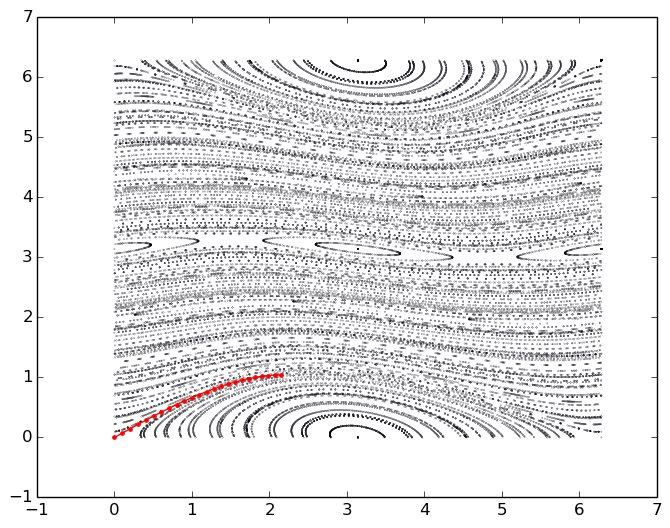

( 0.8123460094785507 t - 0.009033906934722882 t³ + 0.0001397361967527743 t⁵ - 2.0738982165943525e-6 t⁷ + 𝒪(t⁸),  0.5831757547123116 t - 0.036765757927698775 t³ + 0.0019509397937700751 t⁵ - 8.94967685358829e-5 t⁷ + 𝒪(t⁸), [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875], [0.0, 5.44223e-20, 4.4051e-19, 1.51603e-18, 3.69306e-18, 7.47032e-18, 1.34718e-17, 2.24937e-17, 3.55618e-17, 5.40015e-17  …  3.06239e-16, 4.14429e-16, 5.55112e-16, 7.36713e-16, 9.69493e-16, 1.26586e-15, 1.6407e-15, 2.11179e-15, 2.7002e-15, 3.43073e-15])

In [125]:
VariedadX, VariedadP,ErrorT,ErrorX=CalculoVariedad(ke,2.9,0.125,E,λvec)

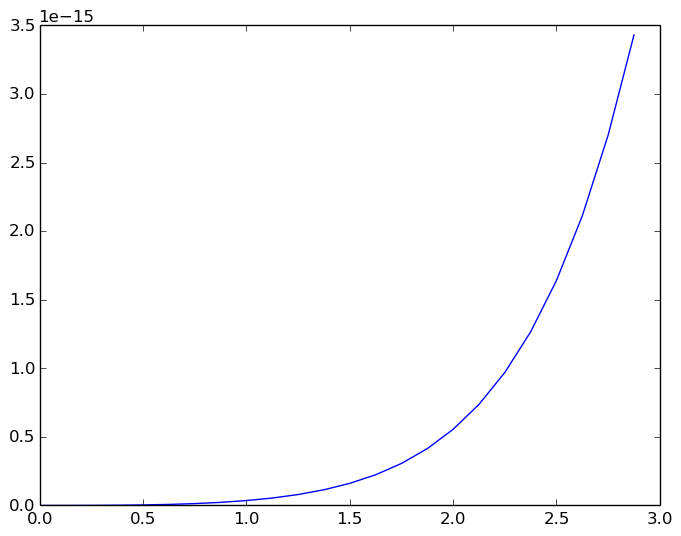

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fee509c27d0>

In [126]:
plot(ErrorT,ErrorX)

Podemos notar que el error crece de manera casi exponencial, aunque el orden del error para t=3.0  es menor a $10^{-15}$